### Genetic Algorithm

In [9]:
import gzip
import csv
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sys import maxsize

In [10]:
def readData(filename):
    
    data = []
    with gzip.open(filename, 'rt') as f:

        tsv_reader = csv.reader(f, delimiter="\t")
        row = next(tsv_reader)
        
        while(row != ['EOF']):
            if row[0][0].isdigit():
                elements = row[0].split(" ")
                final = []
                for ele in elements:
                    if ele != '':
                        final.append(ele)

                data.append([float(final[1]), float(final[2])])
            row = next(tsv_reader)
            
    data = np.array(data)
    
    return data

In [11]:
def length_of_tour(Initial_tour, distance):
    round_tour = Initial_tour[1:]
    round_tour.append(Initial_tour[0])
    
    total_distance = 0
    
    for i, j in zip(Initial_tour, round_tour):
        total_distance += distance[i][j]
        
    return total_distance

In [12]:
from random import random, sample, randint

def fittest_route(possible_routes):
    global distance
    fittest = possible_routes[0]
    for route in possible_routes:
        route.fitness_of_route
        fittest.fitness_of_route
        if route.route_fitness > fittest.route_fitness:
            fittest = route
    return fittest



def parent1_genes(child, parent, length):
    start_index = randint(0, len(parent)-length-1)
    finish_index = start_index + length
    for i in range(start_index, finish_index):
        child.route[i] = parent[i]

        
def parent2_genes(child, parent):
    j = 0
    for i in range(0, len(parent)):
        if child.route[i] == None:
            while parent[j] in child.route:
                j += 1
            child.route[i] = parent[j]
            j += 1

            
def crossover(parent1, parent2):
    parent1_route = parent1.route
    parent2_route = parent2.route
    length = len(parent1_route)
    child = Routes([None for _ in range(length)])
    parent1_genes(child, parent1_route, length // 2)
    parent2_genes(child, parent2_route)

    return child


def mutate(route, mutation_rate):
    for i in range(len(route.route)):
        if random() < mutation_rate:
            swap = sample(route.route, 2)
            index1 = route.route.index(swap[0])
            index2 = route.route.index(swap[1])
            route.route[index2], route.route[index1] = route.route[index1], route.route[index2]
            route.route_length  = 0
            route.route_fitness = 0
    return route

In [13]:
def evolve(possible_routes):
    global distance
    tourn_size = 2
    mutation_rate = 0.01
    population_length = len(possible_routes)
    top_best = population_length // 2
    new_population = []
    
    for i in range(top_best):
        fittest = fittest_route(possible_routes)
        new_population.append(fittest)
        possible_routes.remove(fittest)

    
    for i in range(top_best, population_length):
        #print(len(new_population))
        parent1 = fittest_route(sample(new_population, tourn_size))
        parent2 = fittest_route(sample(new_population, tourn_size))
        child = crossover(parent1, parent2)
        new_population.append(child)

    
    for i in range(top_best, population_length):
        route = mutate(new_population[i], mutation_rate)
        new_population[i] = route

    return new_population

In [14]:
class Routes:
    global distance
    def __init__(self, route):
        self.route         = route
        self.route_length  = 0
        self.route_fitness = 0
        
    @property
    def length_of_route(self):
        if self.route_length == 0:
            self.route_length += length_of_tour(self.route, distance)
        return self.route_length
    
    @property
    def fitness_of_route(self):
        if self.route_fitness == 0:
            self.route_fitness = 1 / self.length_of_route
        return self.route_fitness

In [15]:
def geneticAlgorithm():
    global distance
    filename             = 'data/eil76.tsp.gz'
    data                 = readData(filename)
    
    start_time = time.time()
    
    data_transpose       = data[:, np.newaxis]
    difference           = np.square(data_transpose - data)
    distance             = np.sqrt(difference.sum(axis=2))
    
    length = len(data)
    population_size = 1000
    Initial_tour    = list(range(length))
    
    possible_routes = []
    for i in range(population_size):
        possible_routes.append(Routes(sample(Initial_tour, len(Initial_tour))))
    
    all_tours = []
    all_tour_distances = []
    fittest = fittest_route(possible_routes)
    route_length = fittest.length_of_route
    all_tour_distances.append(fittest.route_length)
    generation = 0
    number_of_gen_equal = 20
    min_tour_distance = maxsize
    new_population = possible_routes
    while generation < number_of_gen_equal:
        
        new_population = evolve(new_population)
        fittest = fittest_route(new_population)
        route_length = fittest.length_of_route
        min_dist = fittest.route_length
        if min_tour_distance > min_dist:
            generation = 0
            min_tour_distance = min_dist
        else:
            generation += 1
        #print(min_dist)
        all_tour_distances.append(min_dist)
        all_tours.append(fittest.route)
        
    best_route = fittest.route
    
    print("Execution time:  %s seconds ---" % (time.time() - start_time))
    print("Distance of Best Tour found: ", all_tour_distances[-1])
    print("Plot for population_size: %d, number_of_gen_equal: %d" %(population_size, number_of_gen_equal))
    plt.plot([i for i in range(len(all_tour_distances))], all_tour_distances)
    line_init = plt.axhline(y=all_tour_distances[0], color='r', linestyle='--')
    line_min = plt.axhline(y=min_tour_distance, color='g', linestyle='--')
    plt.legend([line_init, line_min], ['Initial_tour_distance', 'Optimized_tour_distance'])
    x = [i for i in range(len(all_tour_distances))]
    plt.title("Genetic Algorithm")
    plt.text(x[len(x)//2], all_tour_distances[10], 'min cost: {} KM'.format(round(all_tour_distances[-1])), ha='center', va='center')
    plt.ylabel('Tour_length')
    plt.xlabel('Number of Rounds')
    
    plt.show()
    
    return best_route, all_tour_distances, data, all_tours

Execution time:  131.88026475906372 seconds ---
Distance of Best Tour found:  702.2471777959539
Plot for population_size: 1000, number_of_gen_equal: 20


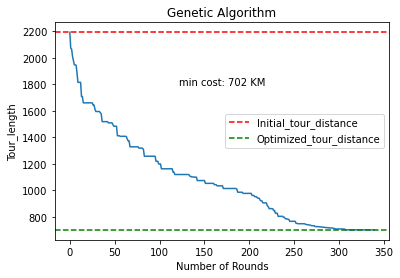

In [18]:
best_tour, all_tour_distances, data, all_tours = geneticAlgorithm()

In [19]:
def visualize(history, points):
    
    key_frames_mult = len(history) // 100
    fig, ax = plt.subplots()
    line, = plt.plot([], [], lw=2)

    def init():
        x = [points[i][0] for i in history[0]]
        y = [points[i][1] for i in history[0]]
        plt.plot(x, y, 'co')
        extra_x = (max(x) - min(x)) * 0.05
        extra_y = (max(y) - min(y)) * 0.05
        ax.set_xlim(min(x) - extra_x, max(x) + extra_x)
        ax.set_ylim(min(y) - extra_y, max(y) + extra_y)
        ax.set_title("Visualization of tour for Genetic Algorithm")
        line.set_data([], [])
        return line,

    def update(frame):
        x = [points[i, 0] for i in history[frame] + [history[frame][0]]]
        y = [points[i, 1] for i in history[frame] + [history[frame][0]]]
        
        line.set_data(x, y)
        return line


    anim = FuncAnimation(fig, update, frames=range(0, len(history), key_frames_mult),
                        init_func=init, interval=30, repeat=False)
    
    anim.save('file.png', fps=10)
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


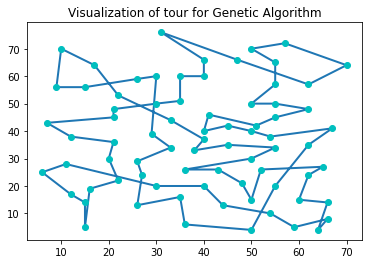

In [20]:
visualize(all_tours, data)